Following the awesome tutorial by Nathaniel Tucker:
    
https://github.com/knathanieltucker/tf-keras-tutorial/blob/master/VGGFaces.ipynb

## VGG Faces

VGG is a famous model in machine learning known for very good image recognician results. Here we are going to use this to recognize faces. One of the last tricks that Keras has to offer is a large community of developers adding models to the enviornment. VGG face is not something new. It was developed as Deep Face Recognition at Oxford and has since been ported over. Below we mock out the model and use pretrained weights to get things up and running as quickly as possible.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
V1_LABELS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v1.npy'
V2_LABELS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy'

VGG16_WEIGHTS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_vgg16.h5'
VGG16_WEIGHTS_PATH_NO_TOP = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5'

VGGFACE_DIR = 'models/vggface'

In [3]:
from keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D, \
    GlobalMaxPooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, \
    AveragePooling2D, Reshape, Permute, multiply
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.engine.topology import get_source_inputs
import warnings
from keras.models import Model
from keras import layers

Using TensorFlow backend.


In [4]:
def VGG16(include_top=True, weights='vggface',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=2622):
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(
        img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(
        x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(
        x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(
        x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, name='fc6')(x)
        x = Activation('relu', name='fc6/relu')(x)
        x = Dense(4096, name='fc7')(x)
        x = Activation('relu', name='fc7/relu')(x)
        x = Dense(classes, name='fc8')(x)
        x = Activation('softmax', name='fc8/softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

            # Ensure that the model takes into account
            # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
        # Create model.
    model = Model(inputs, x, name='vggface_vgg16')  # load weights
    if weights == 'vggface':
        if include_top:
            weights_path = get_file('rcmalli_vggface_tf_vgg16.h5',
                                    VGG16_WEIGHTS_PATH,
                                    cache_subdir=VGGFACE_DIR)
        else:
            weights_path = get_file('rcmalli_vggface_tf_notop_vgg16.h5',
                                    VGG16_WEIGHTS_PATH_NO_TOP,
                                    cache_subdir=VGGFACE_DIR)
        model.load_weights(weights_path, by_name=True)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='pool5')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc6')
                layer_utils.convert_dense_weights_data_format(dense, shape,
                                                              'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [5]:
from __future__ import print_function

def VGGFace(include_top=True, weights='vggface',
            input_tensor=None, input_shape=None,
            pooling=None,
            classes=None):
    """Instantiates the VGGFace architectures.
    Optionally loads weights pre-trained
    on VGGFace datasets. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "vggface" (pre-training on VGGFACE datasets).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """

    if weights not in {'vggface', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `vggface`'
                         '(pre-training on VGGFace Datasets).')

    if classes is None:
        classes = 2622

    if weights == 'vggface' and include_top and classes != 2622:
        raise ValueError(
            'If using `weights` as vggface original with `include_top`'
            ' as true, `classes` should be 2622')

    return VGG16(include_top=include_top, input_tensor=input_tensor,
                 input_shape=input_shape, pooling=pooling,
                 weights=weights,
                 classes=classes)

In [6]:
def preprocess_input(x, data_format=None, version=1):
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}
    if version == 1:
        if data_format == 'channels_first':
            x = x[:, ::-1, ...]
            x[:, 0, :, :] -= 93.5940
            x[:, 1, :, :] -= 104.7624
            x[:, 2, :, :] -= 129.1863
        else:
            x = x[..., ::-1]
            x[..., 0] -= 93.5940
            x[..., 1] -= 104.7624
            x[..., 2] -= 129.1863
    else:
        raise NotImplementedError
    return x

In [7]:
def decode_predictions(preds, top=5):
    LABELS = None
    if len(preds.shape) == 2:
        if preds.shape[1] == 2622:
            fpath = get_file('rcmalli_vggface_labels_v1.npy',
                             V1_LABELS_PATH,
                             cache_subdir=VGGFACE_DIR)
            LABELS = np.load(fpath)
        elif preds.shape[1] == 8631:
            fpath = get_file('rcmalli_vggface_labels_v2.npy',
                             V2_LABELS_PATH,
                             cache_subdir=VGGFACE_DIR)
            LABELS = np.load(fpath)
        else:
            raise ValueError('`decode_predictions` expects '
                             'a batch of predictions '
                             '(i.e. a 2D array of shape (samples, 2622)) for V1 or '
                             '(samples, 8631) for V2.'
                             'Found array with shape: ' + str(preds.shape))
    else:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 2622)) for V1 or '
                         '(samples, 8631) for V2.'
                         'Found array with shape: ' + str(preds.shape))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [[str(LABELS[i].encode('utf8')), pred[i]] for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results

In [8]:
model = VGGFace()

In [9]:
from keras.preprocessing import image
img = image.load_img('img/ajb.jpg', target_size=(224, 224))

In [10]:
import numpy as np
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [11]:
x = preprocess_input(x, version=1)

In [12]:
preds = model.predict(x)
preds

array([[  9.79011595e-01,   4.98706392e-08,   7.08651669e-07, ...,
          5.43792247e-08,   7.66426581e-07,   3.70702026e-07]], dtype=float32)

In [13]:
'Predicted:', decode_predictions(preds)

('Predicted:',
 [[['A.J._Buckley', 0.9790116],
   ['David_Denman', 0.0014457349],
   ['Carmine_Giovinazzo', 0.00086765271],
   ['Robert_Buckley', 0.00072456809],
   ['Eddie_Cahill', 0.00041833066]]])

In [14]:
img = image.load_img('img/ajb_2.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x, version=1)
preds = model.predict(x)
'Predicted:', decode_predictions(preds)

('Predicted:',
 [[['A.J._Buckley', 0.97731692],
   ['Carmine_Giovinazzo', 0.0049797781],
   ['Eddie_Cahill', 0.0028231405],
   ['Robert_Buckley', 0.0023357254],
   ['Josh_Lucas', 0.0020591642]]])

In [15]:
img = image.load_img('img/me.png', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x, version=1)
preds = model.predict(x)
'Predicted:', decode_predictions(preds)

('Predicted:',
 [[['Ben_Feldman', 0.043971587],
   ['Michael_Stahl-David', 0.039932199],
   ['Martin_Starr', 0.031861968],
   ['Wes_Ramsey', 0.024007753],
   ['Ralf_Little', 0.021356979]]])

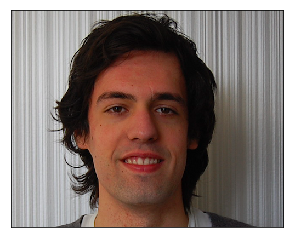

In [16]:
import matplotlib.image as mpimg
img = mpimg.imread('img/me.png')
plt.imshow(img)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [18]:
from keras import backend as K

input_layer = model.layers[0]
input_layer_fxn = K.function([model.input], [input_layer.output])
input_activation = input_layer_fxn([x])

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

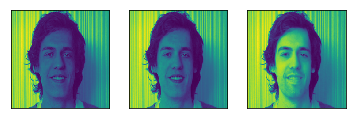

In [20]:
for i in range(3):
    plt.subplot(1, 3, i+1)
    act = input_activation[0][0, :, :, i]
    plt.imshow(act)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

In [21]:
first_conv = model.get_layer('pool1')
first_conv_activation_fxn = K.function([model.input], [first_conv.output])
first_conv_activation = first_conv_activation_fxn([x])

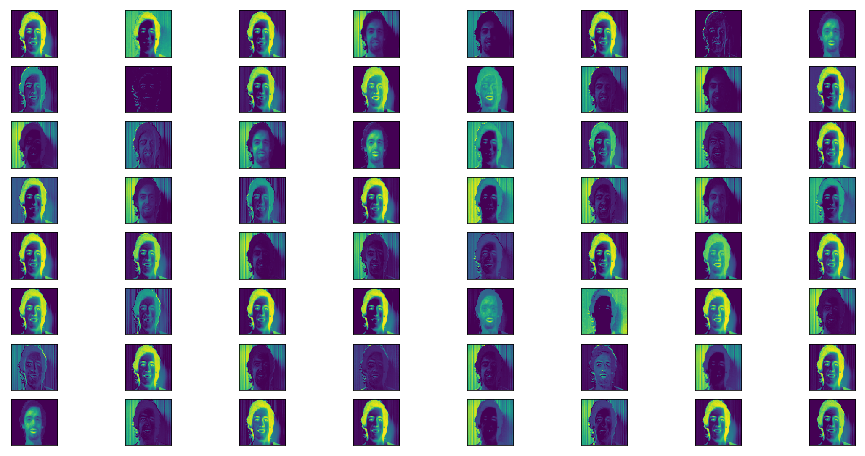

In [22]:
plt.figure(figsize=(16, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    act = first_conv_activation[0][0, :, :, i]
    plt.imshow(act)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

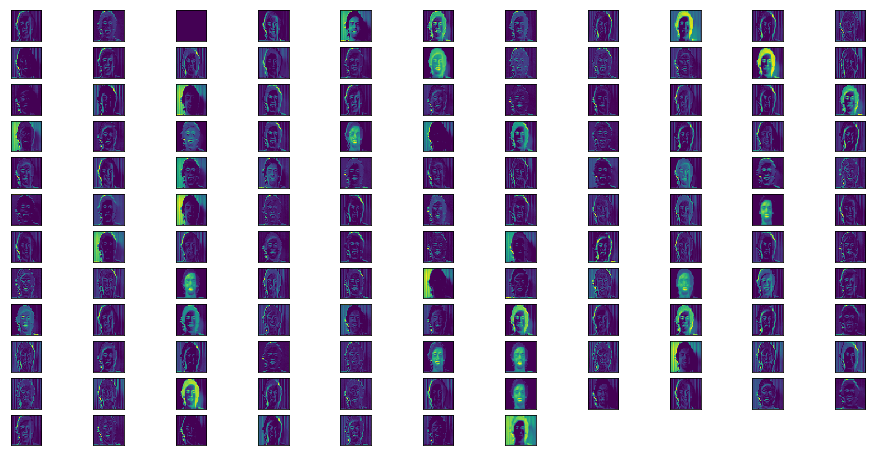

In [23]:
first_conv = model.get_layer('pool2')
first_conv_activation_fxn = K.function([model.input], [first_conv.output])
first_conv_activation = first_conv_activation_fxn([x])

plt.figure(figsize=(16, 8))
for i in range(128):
    plt.subplot(12, 11, i+1)
    act = first_conv_activation[0][0, :, :, i]
    plt.imshow(act)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

In [24]:
import numpy as np
x_insight = np.load('insight_x.npy')
y_insight = np.load('insight_y.npy')

In [25]:
x_insight.shape, y_insight.shape

((411, 224, 224, 3), (411,))

In [26]:
x_insight[0].shape, y_insight[0]

((224, 224, 3), 315)

In [27]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input

#custom parameters
nb_class = 411
hidden_dim = 512

image_input = Input(shape=(224, 224, 3))
# for theano uncomment
# image_input = Input(shape=(3,224, 224))
vgg_model = VGGFace(input_tensor=image_input, include_top=False)
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(image_input, out)

58925056/58909280 [==============================] - 24s 0us/step


In [29]:
x_train = preprocess_input(x_insight, version=1)

In [37]:
x_train.shape

(411, 224, 224, 3)

In [31]:
import keras
y_train = keras.utils.to_categorical(y_insight, nb_class)

In [35]:
y_train[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [38]:
# Train your model as usual.

from keras.callbacks import TensorBoard

custom_vgg_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adadelta', 
    metrics=['accuracy'])

In [40]:
custom_vgg_model.fit(
    x_train, 
    y_train, 
    epochs=1, 
    batch_size=50, 
    validation_split=0.1, 
    callbacks=[TensorBoard(log_dir='insight_logs', histogram_freq=1, write_images=True)])

Train on 369 samples, validate on 42 samples
Epoch 1/1
369/369 [==============================] - 1490s 4s/step - loss: 16.0307 - acc: 0.0054 - val_loss: 15.7343 - val_acc: 0.0238
